In [1]:
import pandas as pd
import torch
import torchvision.transforms.functional as F
from EnsembleXAI import Ensemble, Metrics
from torchvision.transforms import Resize, CenterCrop
import os
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import urllib.request
import json
import matplotlib.pyplot as plt
import pickle

In [2]:
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    imagenet_classes_dict = json.load(url)
with urllib.request.urlopen("https://raw.githubusercontent.com/LUSSeg/ImageNet-S/main/data/categories/ImageNetS_categories_im50.txt") as url:
    imagenetS50_ids_dict = {str(x).replace("b'", "").replace("\\n'", "").replace("'",""):i+1 for i, x in enumerate(url)}

In [3]:
def download_class_images(class_id, masks_path):
    full_path = masks_path + class_id + "\\"
    kaggle_path = f"/ILSVRC/Data/CLS-LOC/train/{class_id}/"
    for file_name in os.listdir(full_path):
        file_name_jpeg = file_name[:-3] + 'JPEG'
        !kaggle competitions download -f {kaggle_path}{file_name_jpeg} -p ./images/{class_id}/ -c imagenet-object-localization-challenge


def download():
    skipped = []
    for class_id in os.listdir(masks_dir):
        image_class_path = os.path.join(images_dir, class_id)
        if os.path.exists(image_class_path) and len(os.listdir(image_class_path)) == 10:
            skipped.append(class_id)
            continue
        #download_class_images(class_id, masks_dir)
        print(f"Downloaded {class_id}")
    print("Full dirs: " + str(len(skipped)))


def images_list(image_path, resize=True):
    _crop = CenterCrop(224).forward
    _resize = Resize(232).forward
    images = []
    for image_name in os.listdir(image_path):
        image = Image.open(image_path + image_name)
        if image.mode == 'L':
            image = image.convert(mode='RGB')
        if resize:
            image = _crop(_resize(image))
        images.append(image)
    return images

def load_all(classid):
    all_img = images_list(images_dir + classid + "\\")
    all_img_org = images_list(images_dir + classid + "\\", resize=False)
    all_tens = [F.to_tensor(img) for img in all_img]
    all_msks = [F.pil_to_tensor(img) for img in images_list(masks_dir + classid + "\\")]
    all_msks = [((temp[1] * 256 + temp[0]) == imagenetS50_ids_dict[classid]).float().repeat(3,1,1) for temp in all_msks]
    all_tens = [tens.repeat(3,1,1) if tens.shape[0]==1 else tens for tens in all_tens]
    tens_img = torch.stack(all_tens)
    tens_msks = torch.stack(all_msks)#[:,0].unsqueeze(dim=1).repeat(1, tens_img.shape[1], 1, 1)
    return all_img, all_img_org, all_tens, all_msks, tens_img, tens_msks

def dict_to_matrix(original_data, explanations_dict, predictor, masks_tensor):
    df = pd.DataFrame()
    #impact_thresh = 0.4
    #accordance_thresh = 0.2
    for key, value in explanations_dict.items():
        for thresh in range(10):
            thresh_val = thresh/10
            df.loc[key, f"DIR{thresh_val}"] = Metrics.decision_impact_ratio(original_data, predictor, value, thresh_val, 0)
            df.loc[key, f"CIR Same{thresh_val}"] = Metrics.confidence_impact_ratio(original_data, predictor, value, thresh_val, 0, compare_to="same_prediction")
            df.loc[key, f"CIR Max{thresh_val}"] = Metrics.confidence_impact_ratio(original_data, predictor, value, thresh_val, 0, compare_to="new_prediction")
            df.loc[key, f"Average Recall{thresh_val}"] = torch.mean(Metrics.accordance_recall(value, masks_tensor, thresh_val)).item()
            df.loc[key, f"Average Precision{thresh_val}"] = torch.mean(Metrics.accordance_precision(value, masks_tensor, thresh_val)).item()
            df.loc[key, f"F1_score{thresh_val}"] = Metrics.F1_score(explanations_dict[key], masks_tensor, thresh_val)
            df.loc[key, f"IOU{thresh_val}"] = Metrics.intersection_over_union(explanations_dict[key], masks_tensor, thresh_val)
    return df

In [4]:
input_dir = "\\".join(os.getcwd().split(sep="\\")[:-2] + ['input'])
masks_dir = input_dir + f'\\ImageNetS50\\train-semi-segmentation\\'
images_dir = os.getcwd() + "\\images\\"
all_classes = next(os.walk(images_dir))[1]
print(all_classes)

['n01443537', 'n01491361', 'n01531178', 'n01644373', 'n02104029', 'n02119022', 'n02123597', 'n02133161', 'n02165456', 'n02281406', 'n02325366', 'n02342885', 'n02396427', 'n02483362', 'n02504458', 'n02510455', 'n02690373', 'n02747177', 'n02783161', 'n02814533', 'n02859443', 'n02917067', 'n02992529', 'n03014705', 'n03047690', 'n03095699', 'n03197337', 'n03201208', 'n03445777', 'n03452741', 'n03584829', 'n03630383', 'n03775546', 'n03791053', 'n03874599', 'n03891251', 'n04026417', 'n04335435', 'n04380533', 'n04404412', 'n04447861', 'n04507155', 'n04522168', 'n04557648', 'n04562935', 'n04612504', 'n06794110', 'n07749582', 'n07831146', 'n12998815']


In [5]:
"""comb_expl = {'Gradients':[], 'Saliency':[], 'Occlusion 25':[], 'Occlusion 15':[]}
for id in all_classes:
    with open(f'results/{id}/explanations.pickle', 'rb') as handle:
        b = pickle.load(handle)
    comb_expl['Gradients'].append(b['Gradients'])
    comb_expl['Saliency'].append(b['Saliency'])
    comb_expl['Occlusion 25'].append(b['Occlusion 25'])
    comb_expl['Occlusion 15'].append(b['Occlusion 15'])
attr_500_ig_nt = torch.cat(comb_expl['Gradients'], dim=0)
attr_500_sal = torch.cat(comb_expl['Saliency'], dim=0)
attr_500_occ_25 = torch.cat(comb_expl['Occlusion 25'], dim=0)
attr_500_occ_15 = torch.cat(comb_expl['Occlusion 15'], dim=0)
all_stacked = torch.stack([attr_500_ig_nt, attr_500_sal, attr_500_occ_25, attr_500_occ_15], dim=1)
attr_agg_avg = Ensemble.basic(all_stacked, aggregating_func='avg')
attr_agg_min = Ensemble.basic(all_stacked, aggregating_func='min')
attr_agg_max = Ensemble.basic(all_stacked, aggregating_func='max')"""

In [5]:
all_50_img = [x for classid in all_classes for x in images_list(images_dir + classid + "\\")]
all_50_tens = torch.stack([F.pil_to_tensor(x) for x in all_50_img])
all_msks = [(classid, [F.pil_to_tensor(img) for img in images_list(masks_dir + classid + "\\")]) for classid in all_classes]
all_msks = torch.stack([((temp_mask[1] * 256 + temp_mask[0]) == imagenetS50_ids_dict[classid]).float().repeat(3,1,1) for classid, classmasks in all_msks for temp_mask in classmasks])
all_50_expl_dicts = [pickle.load(open(f'results/{classid}/explanations.pickle', 'rb')) for classid in all_classes]
all_500_expl_dict = {key:torch.cat([expl_dict[key] for expl_dict in all_50_expl_dicts], dim=0) for key in all_50_expl_dicts[0].keys()}
data_stacked = torch.stack(list(all_500_expl_dict.values())[:-3], dim=1)

In [8]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()
resnet_transform = ResNet50_Weights.DEFAULT.transforms()
pipeline = lambda images: torch.stack([resnet_transform(image) for image in images])
all_500_org = pipeline([x for classid in all_classes for x in images_list(images_dir + classid + "\\", resize=False)])
data_before = all_500_org
import gc
predict_test = lambda x: torch.nn.Softmax(dim=0)(model(x))
all = []
for i in range(50):
    gc.collect(2)
    res = predict_test(all_500_org[i * 10:(i + 1) * 10]).detach()
    all.append(res)
org_preds = torch.cat(all, dim=0)

def predict_loop(x):
    all = []
    if torch.all(x == data_before):
        return org_preds
    else:
        for i in range(50):
            gc.collect(2)
            res = predict_test(x[i*10:(i+1)*10]).detach()
            all.append(res)
        return torch.cat(all, dim=0)

In [24]:
#simple_dict = {'Baseline_masks':all_msks}
#simple_agg_res =  dict_to_matrix(all_500_org, simple_dict, predict_loop, all_msks)
#simple_agg_res.to_csv('simple_fix.csv')

In [5]:
aggregated_csvs = pd.read_csv('imagenet_aggregated_results.csv', index_col=0)
max_single_agg = aggregated_csvs.loc[['Gradients', 'Saliency', 'Occlusion 25', 'Occlusion 15']].max(axis=0)
max_agg_agg = aggregated_csvs.loc[['Max Aggregate', 'Min Aggregate', 'Avg Aggregate']].max(axis=0)
max_krr_agg = aggregated_csvs.loc[['SE', 'SES', 'SEWOD', 'SEWODS']].max(axis=0)
max_baseline_agg = aggregated_csvs.loc[['Baseline_black', 'Baseline_white', 'Baseline_masks']].max(axis=0)

In [6]:
aggregated_csvs.loc[['Baseline_black', 'Baseline_white']]

,DIR0.0,CIR Same0.0,CIR Max0.0,Average Recall0.0,Average Precision0.0,F1_score0.0,IOU0.0,DIR0.1,CIR Same0.1,CIR Max0.1,...,Average Precision0.8,F1_score0.8,IOU0.8,DIR0.9,CIR Same0.9,CIR Max0.9,Average Recall0.9,Average Precision0.9,F1_score0.9,IOU0.9
Baseline_black,0.046,0.001227,0.001002,0.00006,0.720000,0.000000,0.000060,0.046,0.001227,0.001002,...,0.720000,0.000000,0.000060,0.046,0.001227,0.001002,0.00006,0.720000,0.000000,0.000060
Baseline_white,1.000,0.371730,0.371730,1.00000,0.363176,0.487792,0.363176,1.000,0.371730,0.371730,...,0.363176,0.487792,0.363176,1.000,0.371730,0.371730,1.00000,0.363176,0.487792,0.363176


In [7]:
[(max_agg_agg.iloc[7*k:]>max_single_agg.iloc[7*k:]).sum()/len(max_single_agg.iloc[7*k:]) for k in range(9)]

[0.6571428571428571,
 0.6825396825396826,
 0.6964285714285714,
 0.6938775510204082,
 0.6904761904761905,
 0.6857142857142857,
 0.6785714285714286,
 0.6666666666666666,
 0.6428571428571429]

In [8]:
[(max_krr_agg.iloc[7*k:]>max_single_agg.iloc[7*k:]).sum()/len(max_single_agg.iloc[7*k:]) for k in range(9)]

[0.7,
 0.7301587301587301,
 0.7321428571428571,
 0.7346938775510204,
 0.7142857142857143,
 0.7142857142857143,
 0.7142857142857143,
 0.7142857142857143,
 0.7142857142857143]

In [9]:
[(max_baseline_agg.iloc[7*k:]>max_single_agg.iloc[7*k:]).sum()/len(max_single_agg.iloc[7*k:]) for k in range(9)]

[0.9714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [10]:
(max_krr_agg-max_single_agg)/(max_single_agg)

DIR0.0                  0.000000e+00
CIR Same0.0             7.353363e-06
CIR Max0.0              5.772374e-08
Average Recall0.0       0.000000e+00
Average Precision0.0    7.593328e-02
                            ...     
CIR Max0.9                       NaN
Average Recall0.9       2.744477e+01
Average Precision0.9    2.027593e+00
F1_score0.9                      NaN
IOU0.9                  2.550296e+01
Length: 70, dtype: float64

In [11]:
aggregated_csvs.iloc[:,35:63] #[1, 3, 3, 3, 4, 4, 4, 4, 4, 2]


,DIR0.5,CIR Same0.5,CIR Max0.5,Average Recall0.5,Average Precision0.5,F1_score0.5,IOU0.5,DIR0.6,CIR Same0.6,CIR Max0.6,...,Average Precision0.7,F1_score0.7,IOU0.7,DIR0.8,CIR Same0.8,CIR Max0.8,Average Recall0.8,Average Precision0.8,F1_score0.8,IOU0.8
Baseline_black,0.046,0.001227,0.001002,0.000060,0.720000,0.000000,0.000060,0.046,0.001227,0.001002,...,0.720000,0.000000,0.000060,0.046,0.001227,0.001002,0.000060,0.720000,0.000000,0.000060
Baseline_white,1.000,0.371730,0.371730,1.000000,0.363176,0.487792,0.363176,1.000,0.371730,0.371730,...,0.363176,0.487792,0.363176,1.000,0.371730,0.371730,1.000000,0.363176,0.487792,0.363176
Baseline_masks,0.820,0.098913,-0.252741,1.000000,1.000000,1.000000,1.000000,0.820,0.098913,-0.252741,...,1.000000,1.000000,1.000000,0.820,0.098913,-0.252741,1.000000,1.000000,1.000000,1.000000
Gradients,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Saliency,0.126,0.001441,-0.003953,0.001106,0.329491,0.000051,0.001072,0.080,0.001801,-0.002117,...,0.198468,0.000000,0.000382,0.050,0.000837,-0.000435,0.000242,0.166099,0.000000,0.000241
Occlusion 25,0.120,0.003374,-0.007203,0.021062,0.146528,0.000000,0.015073,0.076,0.002979,-0.005697,...,0.082030,0.000000,0.008979,0.058,0.003037,-0.002569,0.010673,0.067433,0.000000,0.006951
Occlusion 15,0.072,0.004902,-0.002603,0.010488,0.154932,0.000000,0.007736,0.050,0.002767,-0.001852,...,0.065985,0.000000,0.004725,0.020,0.000809,-0.001786,0.005834,0.046808,0.000000,0.004175
Min Aggregate,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Avg Aggregate,0.030,0.000936,-0.002277,0.006019,0.062413,0.000000,0.003992,0.022,0.000960,-0.001727,...,0.022552,0.000000,0.002538,0.010,0.000918,-0.000554,0.003405,0.014385,0.000000,0.002004
Max Aggregate,0.204,0.009184,-0.008603,0.023742,0.361491,0.000000,0.016836,0.130,0.006247,-0.007049,...,0.230732,0.000000,0.009724,0.098,0.003915,-0.004064,0.011943,0.201609,0.000000,0.008095


In [12]:
from matplotlib.patches import Rectangle
def show_image_bbox(image, bboxes: pd.DataFrame, ax=None):
    if ax is not None:
        ax.imshow(image)
    else:
        plt.imshow(image)
        ax = plt.gca()
    for idx, bbox in bboxes.iterrows():
        x = (bbox[0] - bbox[2] / 2) * 512
        y = (bbox[1] - bbox[3] / 2) * 512

        rect = Rectangle((x, y), bbox[2] * 512, bbox[3] * 512, fill=False, edgecolor='r')
        ax.add_patch(rect)

def plot_results(df):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True)
    for idx, metric in enumerate(["DIR", "CIR Same", "CIR Max", "Average Recall", "Average Precision", "F1_score", "IOU"]):
        metric_df = df.loc[:, [metric in i for i in df.columns]]
        metric_df.columns = [i/10 for i in range(10)]
        metric_df.transpose().plot(title=metric, xlabel='threshold', ax=ax[idx%2][idx//2], legend=False)
        if idx == 6:
            h, l = ax[idx%2][idx//2].get_legend_handles_labels()

    ax[1][3].legend(h, l, loc='upper left', fontsize='xx-large', frameon=False, markerscale=2)
    ax[1][3].set_axis_off()

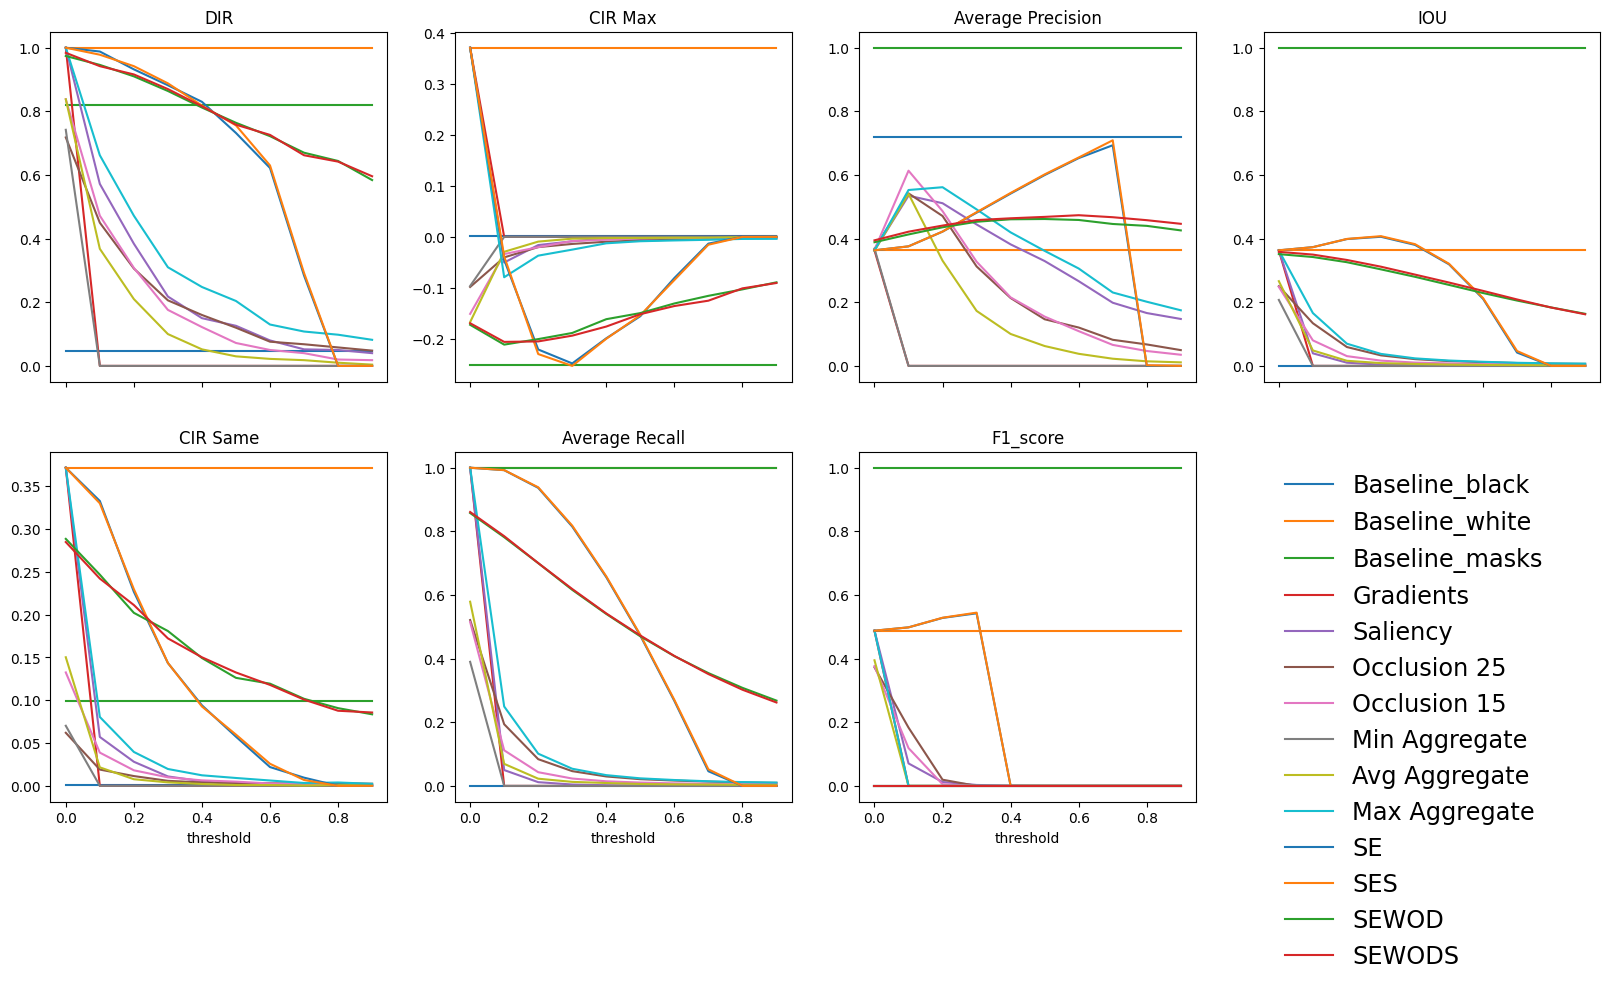

In [13]:
plot_results(aggregated_csvs)

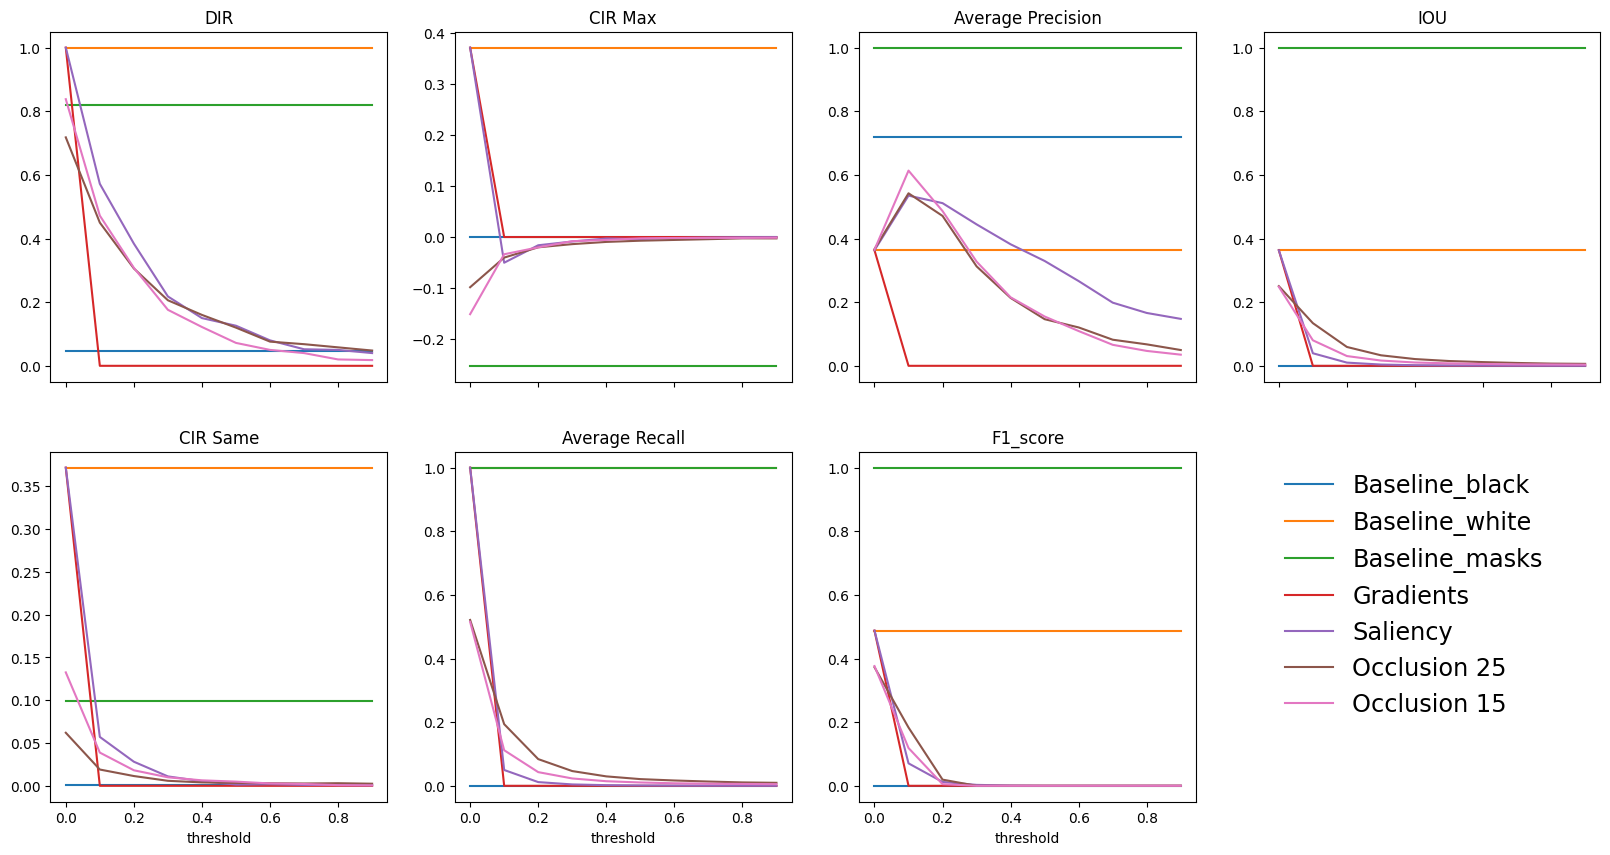

In [14]:
plot_results(aggregated_csvs.loc[['Baseline_black', 'Baseline_white', 'Baseline_masks', 'Gradients',
                                       'Saliency', 'Occlusion 25', 'Occlusion 15']])

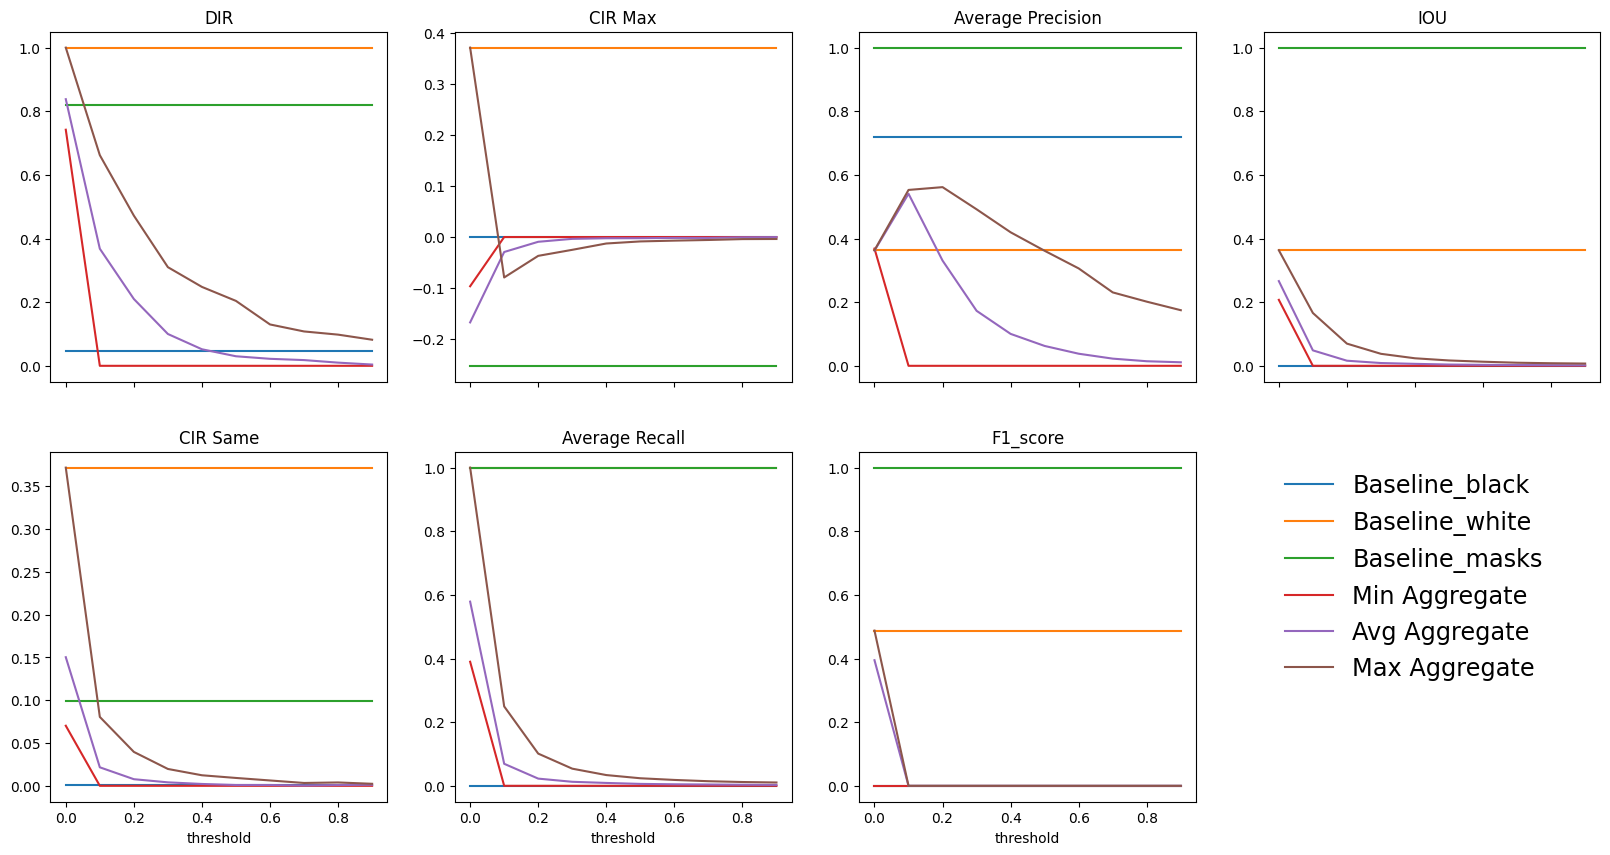

In [15]:
plot_results(aggregated_csvs.loc[['Baseline_black', 'Baseline_white', 'Baseline_masks', 'Min Aggregate',
                     'Avg Aggregate', 'Max Aggregate']])

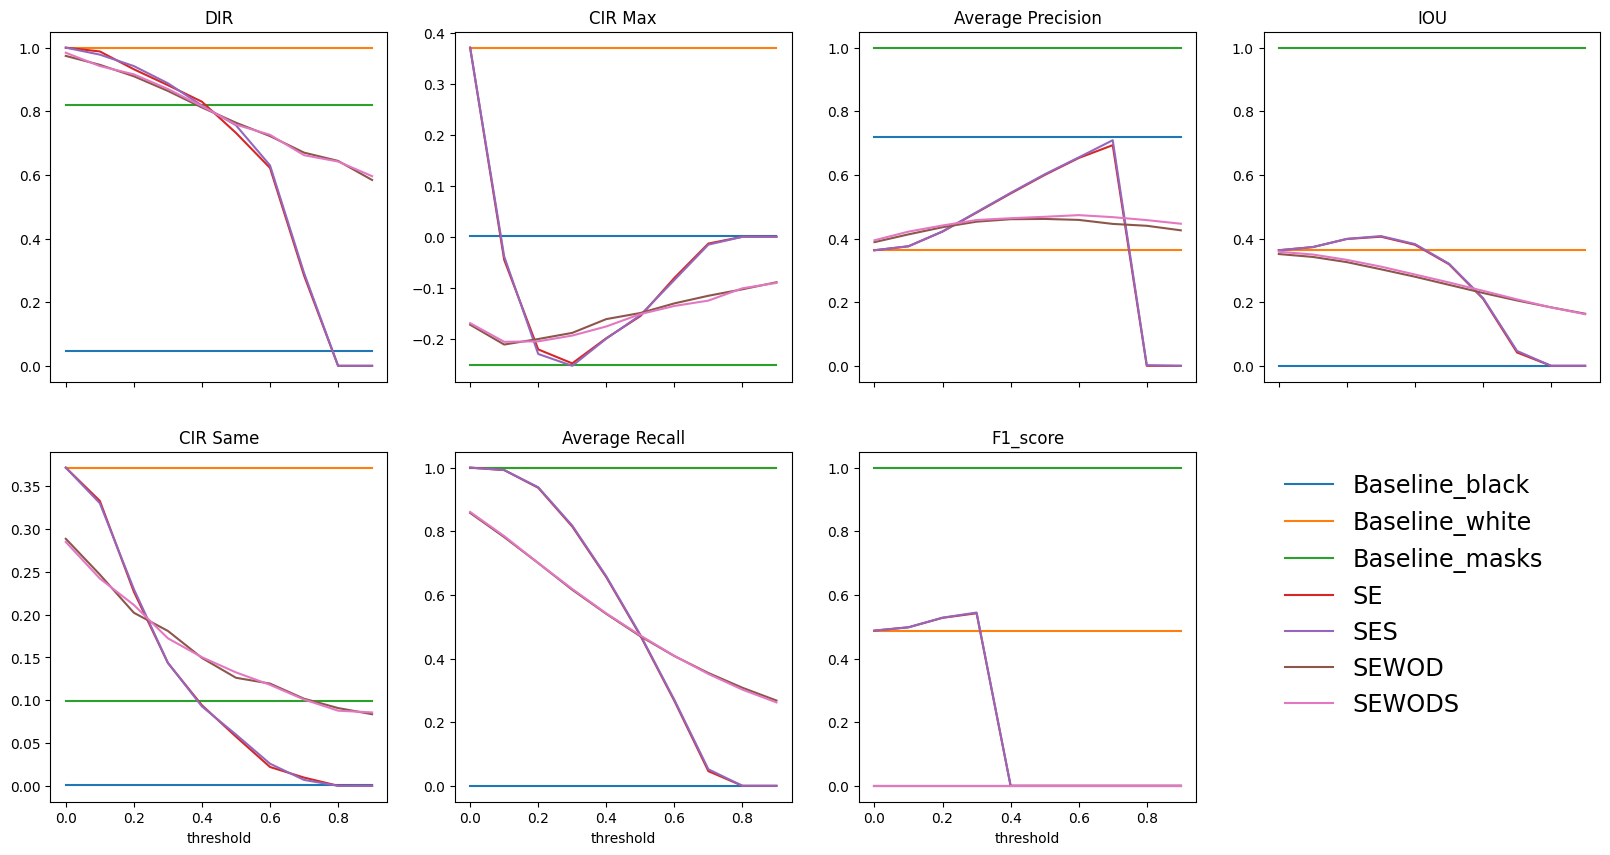

In [16]:
plot_results(aggregated_csvs.loc[['Baseline_black', 'Baseline_white', 'Baseline_masks', 'SE', 'SES', 'SEWOD', 'SEWODS']])

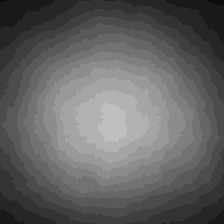

In [13]:
from torchvision.transforms import ToPILImage
avg = torch.mean(all_msks, dim=0)
avg = sum([avg>(i/20) for i in range(20)])/20
ToPILImage()(avg)

In [14]:
torch.unique(avg, return_counts=True)

(tensor([0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000, 0.4500,
         0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500]),
 tensor([  213,  6132, 11151, 14007, 14979, 16245, 14787, 12756, 12096, 10791,
          9822,  9018,  8970,  7047,  2514]))

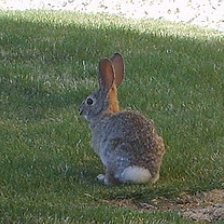

In [20]:
ToPILImage()(all_50_tens[100])

In [ ]:
def load(path):
    with open(path, 'rb') as handle:
        boo = pickle.load(handle)
        return torch.stack([boo, boo, boo], dim = 1)
SE = load('results/All500SupervisedExplanations.pickle')
SES = load('results/All500SupervisedExplanationsShuffled.pickle')
SEOD = load('results/All500SupervisedExplanationsWithOrgData.pickle')
SESOD = load('results/All500SupervisedExplanationsWithOrgDataShuffled.pickle')
expl_dict = {"SE":SE[100].unsqueeze(dim=0), "SES":SES[100].unsqueeze(dim=0),
             "SEOD":SEOD[100].unsqueeze(dim=0), "SESOD":SESOD[100].unsqueeze(dim=0)}
predicted_names = ["wood_rabbit"]

In [61]:
from captum.attr import visualization as viz
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

def plot_explanations(images, explanations_dict, classes_predicted,
                      #cmaps=[default_cmap, None, None, None, None, None, None],
                      method = "heat_map"):
    nrow, ncol = len(images), len(explanations_dict.keys())+1
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize=(14, 3*nrow))
    columns_names = ["Mask"] + list(explanations_dict.keys())
    for col, col_name in zip(ax, columns_names):
        col.title.set_text(col_name)
    for i, img in enumerate(images):
        ax[i].xaxis.set_ticks_position("none")
        ax[i].yaxis.set_ticks_position("none")
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].imshow(np.array(images[i]), vmin=0, vmax=255)
        ax[i].set_ylabel(classes_predicted[i], size='large')
        for j, (col, (key, explanations)) in enumerate(zip(ax[1:], explanations_dict.items())):
            #ith image, jth explanation
            #expl = explanations[i,j]
            expl = explanations[0]
            sign = "all"
            cmap=None
            #if expl.amin() >= 0:
            #    sign = "positive"
            #    cmap = default_cmap
            _ = viz.visualize_image_attr(np.transpose(expl.squeeze().numpy(), (1,2,0)),
                                         original_image=np.array(img),
                                         method=method,
                                         sign=sign,
                                         plt_fig_axis=(fig, col),
                                         show_colorbar=True,
                                         outlier_perc=2,
                                         cmap=cmap,
                                         use_pyplot=False
                                         )
    #plt.savefig(f"results/{id}/plots.png")
    plt.show()

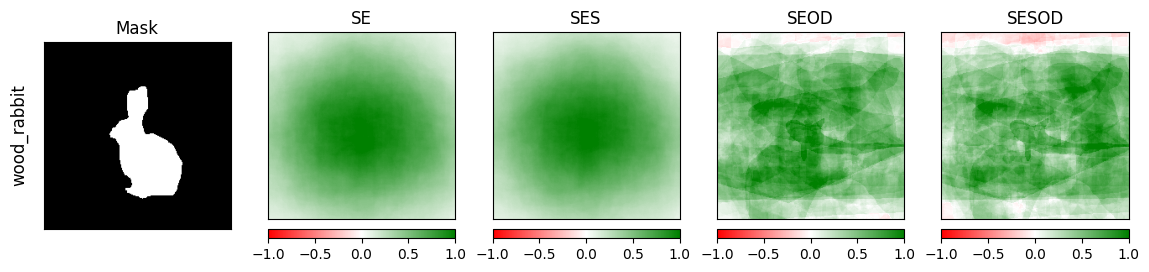

In [62]:
plot_explanations([F.to_pil_image(all_msks[100])], expl_dict, predicted_names, method="heat_map")

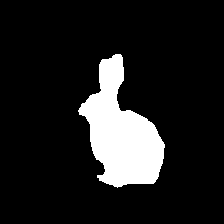

In [58]:
F.to_pil_image(all_msks[100])